## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Compute the camera calibration matrix and distortion coefficients given a set of chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

def get_objpoints_imgpoints(draw):
    patternSize = (9, 6)
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('../camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, patternSize, None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            if draw:
                img = cv2.drawChessboardCorners(img, patternSize, corners, ret)
                cv2.imshow('img', img)
                cv2.waitKey(500)

    cv2.destroyAllWindows()
    return objpoints, imgpoints

In [2]:
import pickle

def calibrateCamera():
    objpoints, imgpoints = get_objpoints_imgpoints(draw = False)
    img = cv2.imread('../camera_cal/calibration1.jpg')
    img_size = (img.shape[1], img.shape[0])
    # Do camera calibration given object points and image points
    ret, cameraMatrix, distCoeffs, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    calibration_data = {"cameraMatrix": cameraMatrix, "distCoeffs": distCoeffs}
    return calibration_data

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
def save_calibration_data(calibration_data):
    pickle.dump(calibration_data, open("../camera_cal/wide_dist_pickle.p", "wb"))

# Read in the saved camera matrix and distortion coefficients
def load_calibration_data():
    calibration_data = pickle.load(open("../camera_cal/wide_dist_pickle.p", "rb"))
    return calibration_data

In [3]:
calibration_data = calibrateCamera()
save_calibration_data(calibration_data)

In [4]:
def undistort(image, calibration_data):
    return cv2.undistort(image,
                         calibration_data['cameraMatrix'],
                         calibration_data['distCoeffs'],
                         None,
                         calibration_data['cameraMatrix'])

## Apply a distortion correction to raw images

adapted from https://github.com/udacity/CarND-Camera-Calibration/blob/master/camera_calibration.ipynb

Text(0.5,1,'Undistorted Image')

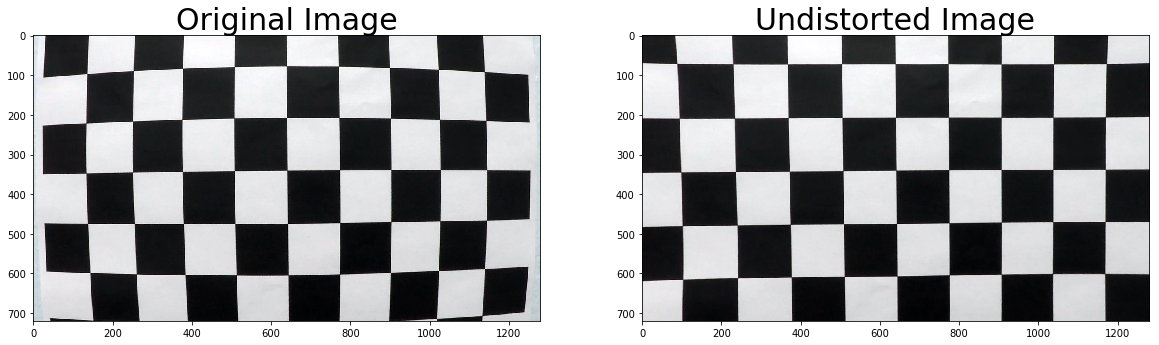

In [5]:
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('../camera_cal/calibration1.jpg')
dst = undistort(img, calibration_data)
cv2.imwrite('../output_images/calibration1_undist.jpg', dst)

#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

## Use color transforms, gradients, etc., to create a thresholded binary image

see https://classroom.udacity.com/nanodegrees/nd013/parts/edf28735-efc1-4b99-8fbb-ba9c432239c8/modules/5d1efbaa-27d0-4ad5-a67a-48729ccebd9c/lessons/144d538f-335d-454d-beb2-b1736ec204cb/concepts/a1b70df9-638b-46bb-8af0-12c43dcfd0b4

Some interesting things to explore might include: the H channel, different threshold values for color and gradient binary images, and even a different color space, like HSV!

Text(0.5,1,'combined_binary')

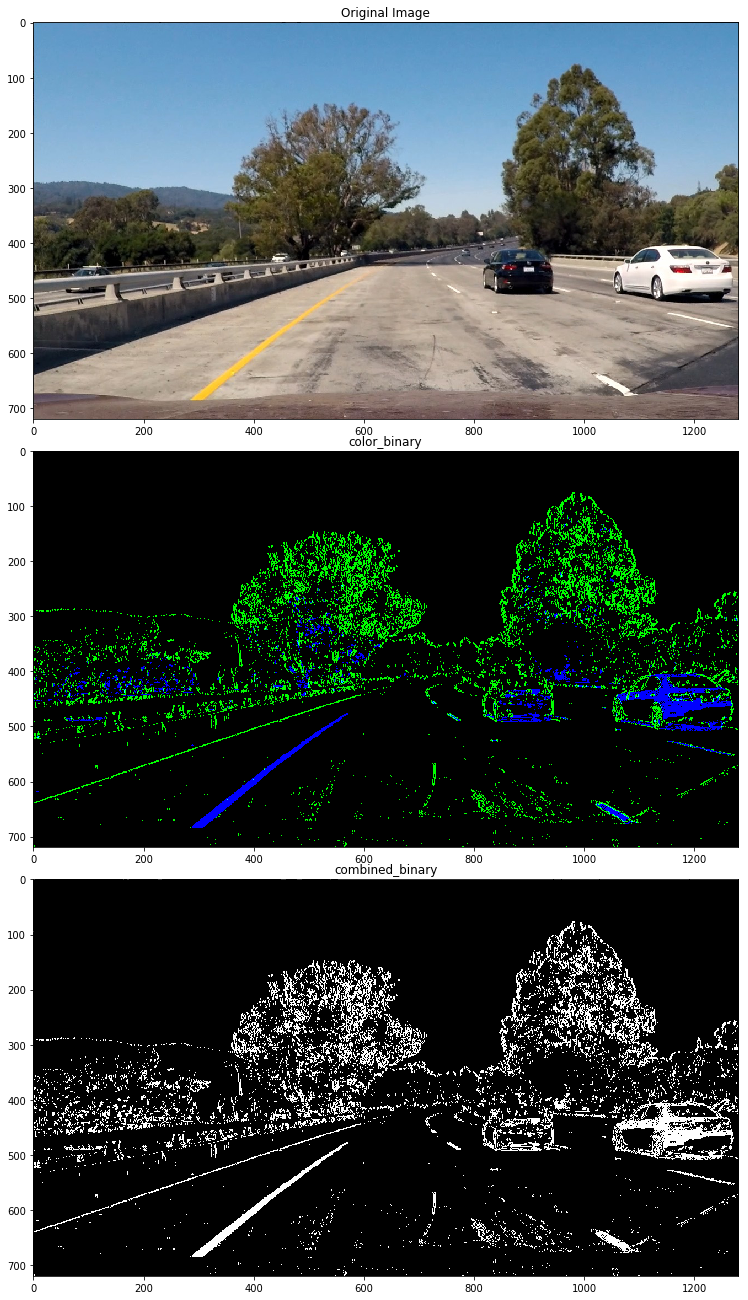

In [6]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image = mpimg.imread('../test_images/test1.jpg')

# Edit this function to create your own pipeline.
def create_binary_images(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return color_binary, combined_binary
    
color_binary, combined_binary = create_binary_images(image)

# Plot the result
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(48, 18))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image')

ax2.imshow(color_binary)
ax2.set_title('color_binary')

ax3.imshow(combined_binary, cmap='gray')
ax3.set_title('combined_binary')

## Apply a perspective transform to rectify binary image ("birds-eye view")

see https://classroom.udacity.com/nanodegrees/nd013/parts/edf28735-efc1-4b99-8fbb-ba9c432239c8/modules/5d1efbaa-27d0-4ad5-a67a-48729ccebd9c/lessons/626f183c-593e-41d7-a828-eda3c6122573/concepts/e6e02d4d-7c80-4bed-a79f-869ef496831b

https://classroom.udacity.com/nanodegrees/nd013/parts/edf28735-efc1-4b99-8fbb-ba9c432239c8/modules/5d1efbaa-27d0-4ad5-a67a-48729ccebd9c/lessons/78afdfc4-f0fa-4505-b890-5d8e6319e15c/concepts/ae58b4d0-b909-4f4b-9332-67d80a1b4029

In [9]:
def get_img_src_dst():
    img = mpimg.imread('../test_images/straight_lines2.jpg')
    img_size = (img.shape[1], img.shape[0])
    src = np.float32(
        [
            ((img_size[0] / 2) - 55, img_size[1] / 2 + 100),
            (((img_size[0] / 6) - 10), img_size[1]),
            ((img_size[0] * 5 / 6) + 60, img_size[1]),
            ((img_size[0] / 2 + 55), img_size[1] / 2 + 100)
        ])
    dst = np.float32(
        [
            ((img_size[0] / 4), 0),
            ((img_size[0] / 4), img_size[1]),
            ((img_size[0] * 3 / 4), img_size[1]),
            ((img_size[0] * 3 / 4), 0)
        ])
    return img, src, dst
    
def getPerspectiveTransform():
    _, src, dst = get_img_src_dst()
    return cv2.getPerspectiveTransform(src, dst)

def warpPerspective(img):
    M = getPerspectiveTransform()
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)
    return warped

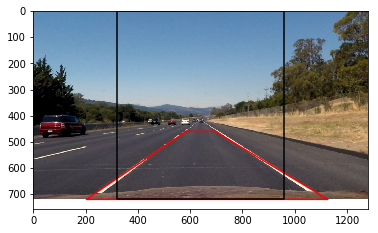

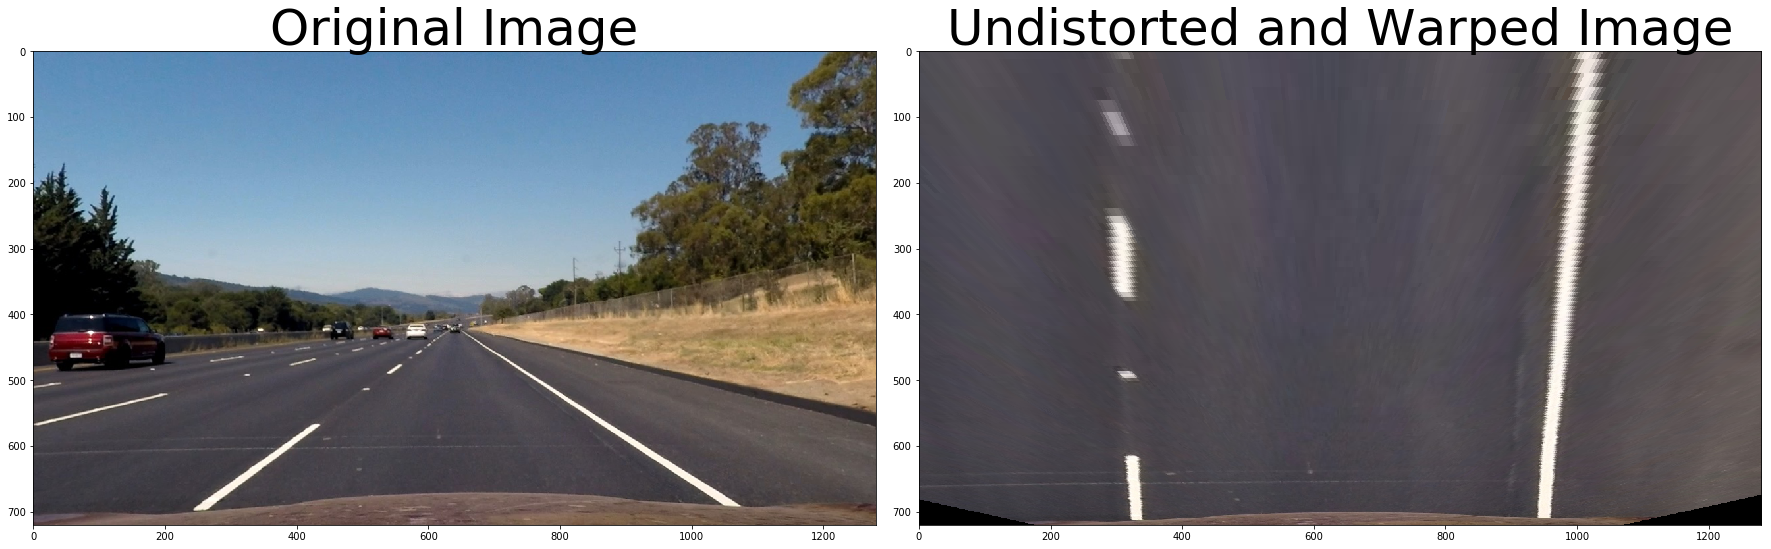

In [11]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def plot_quadrangle(quadrangle, style):
    plt.plot(
        [quadrangle[0][0], quadrangle[1][0], quadrangle[2][0], quadrangle[3][0], quadrangle[0][0]],
        [quadrangle[0][1], quadrangle[1][1], quadrangle[2][1], quadrangle[3][1], quadrangle[0][1]],
        style)


calibration_data = load_calibration_data()

# Read in an image
img, src, dst = get_img_src_dst()
undist = undistort(img, calibration_data)

plt.imshow(undist)
        
plot_quadrangle(src, 'r-')
plot_quadrangle(dst, 'k-')
# TODO: das rote quadrangle (src) auf das Bild undist zeichnen und mittransformieren lassen mit warper => warped
warped = warpPerspective(undist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undist)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

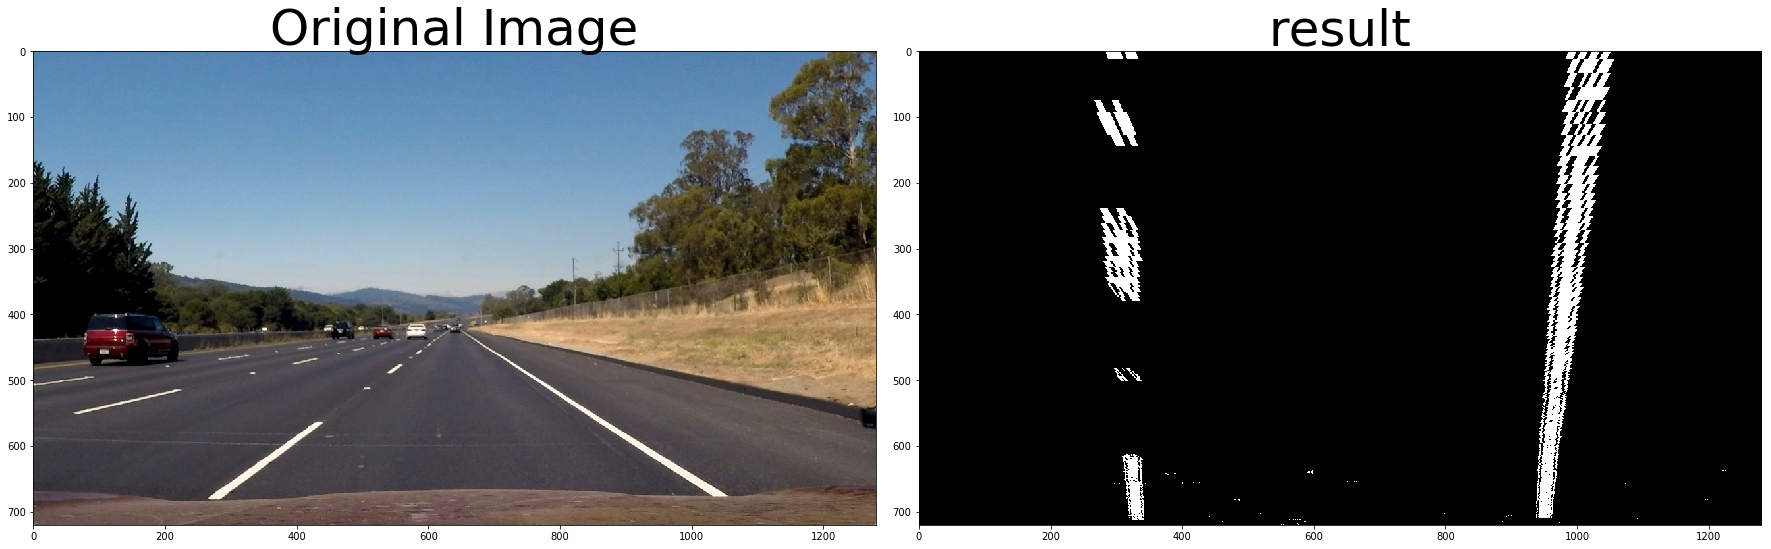

In [16]:
def pipeline(image):
    calibration_data = calibrateCamera()
    save_calibration_data(calibration_data)
    image = undistort(image, calibration_data)
    _, image = create_binary_images(image)
    image = warpPerspective(image)
    return image

image = mpimg.imread('../test_images/straight_lines2.jpg')
result = pipeline(image)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)

ax2.imshow(result, cmap='gray')
ax2.set_title('result', fontsize=50)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Detect lane pixels and fit to find the lane boundary